In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey
from statsmodels.regression.mixed_linear_model import MixedLM


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u
from STX3KO_analyses.single_cell_stats import CellStats 

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# add permuted field detection

# field appearance and shift


In [3]:
figdir = "/mnt/BigDisk/YMazeResults/neural/wta_comparisons"
os.makedirs(figdir,exist_ok=True)

In [4]:
sess = u.load_single_day(ko_mice[0],0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [8]:
class LMM_CellStats:

    def __init__(self, days = np.arange(6), ts_key = 'spks'):

        '''


        :param days:
        :param ts_key:
        '''

        self.ko_mice = stx.ymaze_sess_deets.ko_mice
        self.ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
        self.__dict__.update({'days': days, 'days_z': sp.stats.zscore(days), 'ts_key': ts_key})
        self.n_days = days.shape[0]

        self.df = pd.DataFrame({'mouse':[],
                                'ko':[],
                                'day':[],
                                'day_norm': [],
                                'dz': [],
                                'ko_x_day': [],
                                'lr':[], 
                                'novfam':[], 
                                'ko_x_novfam': [],
                                'novfam_x_day': [],
                                'speed':[],
                                'avg_std': [],
                                'avg_skewness': [],
                                'avg_kurtosis': [],
                                'skewness': [],
                                'max_counts': [],
                                'field_width': [],
                                'intercept': [],})
        self.fill_df()
#         self.df['speed'].apply(sp.stats.zscore)
        





    def fill_df(self):
        for mouse in self.ko_mice:
            for day, dz in zip(self.days,self.days_z):
                self.get_stats(u.load_single_day(mouse, day), 1, day, dz)
                
        for mouse in self.ctrl_mice:
            for day, dz in zip(self.days, self.days_z):
                self.get_stats(u.load_single_day(mouse,day),0, day, dz)
                
                
                

    def get_stats(self, sess, ko, day, dz, ts_key: str = 'spks'):
        '''

        :param sess:
        :param ts_key:
        :param fam:
        :return:
        '''
        
        for _arm, arm in enumerate([-1, 1]):
            trial_mask = sess.trial_info['LR']==arm
            if sess.novel_arm == arm:
                cell_mask = sess.nov_place_cell_mask()
                nov = 1
            else:
                cell_mask = sess.fam_place_cell_mask()
                nov = 0



            trial_mat = sess.trial_matrices[ts_key][:, :, cell_mask]
            trial_mat = trial_mat[trial_mask, :, :]
            trial_mat[np.isnan(trial_mat)] = 1E-5
            
            
            
            
            avg_trial_mat = trial_mat.mean(axis=0, keepdims = True)


            inds = np.arange(0, trial_mat.shape[1])[np.newaxis, :, np.newaxis]

            avg_trial_mat_norm = avg_trial_mat / (np.nansum(avg_trial_mat, axis=1, keepdims=True) + 1E-5)
            avg_com = (avg_trial_mat_norm * inds).sum(axis=1, keepdims=True)
            avg_std = np.power((np.power(inds - avg_com, 2) * avg_trial_mat_norm).sum(axis=1, keepdims=True), .5)
            avg_skewness = (np.power((inds - avg_com) / (avg_std + 1E-5), 3) * avg_trial_mat_norm).sum(axis=1)
            avg_kurtosis = (np.power((inds - avg_com) / (avg_std + 1E-5), 4) * avg_trial_mat_norm).sum(axis=1)
            
            trial_mat_sm = sp.ndimage.filters.gaussian_filter1d(trial_mat, 3, axis=0)
            trial_mat_sm_norm = trial_mat_sm / (np.nansum(trial_mat_sm, axis=1, keepdims=True) + 1E-5)
        
            com = (trial_mat_sm_norm * inds).sum(axis=1, keepdims=True)
            std = np.power((np.power(inds - com, 2) * trial_mat_sm_norm).sum(axis=1, keepdims=True), .5)

            skewness = (np.power((inds - com) / (std + 1E-5), 3) * trial_mat_sm_norm).sum(axis=1)
            kurtosis = (np.power((inds - com) / (std + 1E-5), 4) * trial_mat_sm_norm).sum(axis=1)

            self.df = self.df.append({'mouse': sess.mouse, 
                                    'ko': ko, 
                                    'day': day,
                                    'day_norm': (day+1)/6.,
                                    'dz': dz,
                                    'ko_x_day': ko*(day+1)/6.,
                                    'lr': _arm, 
                                    'novfam': nov, 
                                    'ko_x_novfam': ko*nov,
                                    'novfam_x_day': nov*(day+1)/6.,
                                    'avg_std': avg_std.mean(),
                                    'avg_skewness': avg_skewness.mean(),
                                    'skewness': skewness.mean(axis=0).mean(),
                                    'avg_kurtosis': avg_kurtosis.mean(),
                                    'max_counts': stx.spatial_analyses.max_counts(avg_trial_mat[0, :, :]).mean(),
                                    'field_width': np.nanmean(stx.spatial_analyses.field_width(avg_trial_mat[0, :, :])),
                                    'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0),axis=0),
                                    'intercept':1}, ignore_index=True)
            

        

       


        

In [9]:
cell_stats = LMM_CellStats()

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 

In [11]:
lmm_res = MixedLM(cell_stats.df['avg_std'], cell_stats.df[['ko', 
                                                           'day', 
                                                           'novfam', 
                                                           'lr', 
                                                           'ko_x_day', 
                                                           'ko_x_novfam', 
                                                           'novfam_x_day',
                                                           'speed',
                                                           'intercept']], cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)


         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_std
No. Observations:   120     Method:             REML   
No. Groups:         10      Scale:              0.0319 
Min. group size:    12      Log-Likelihood:     16.2039
Max. group size:    12      Converged:          Yes    
Mean group size:    12.0                               
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
ko            0.209    0.090  2.331 0.020  0.033  0.385
day          -0.042    0.022 -1.907 0.056 -0.086  0.001
novfam       -0.604    0.082 -7.373 0.000 -0.765 -0.443
lr            0.058    0.033  1.728 0.084 -0.008  0.123
ko_x_day     -0.001    0.166 -0.009 0.993 -0.327  0.324
ko_x_novfam   0.179    0.065  2.749 0.006  0.051  0.307
novfam_x_day  0.290    0.115  2.530 0.011  0.065  0.514
speed        -0.439    0.383 -1.148 0.251 -1.189  0.311
i

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


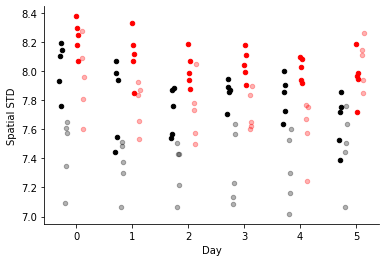

In [18]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_std'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Spatial STD')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "avg_std_summary.pdf"))

In [24]:
# lmm_res = MixedLM(cell_stats.df['max_counts'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['max_counts'], cell_stats.df[['ko', 
                                                              'day', 
                                                              'novfam', 
                                                              'lr', 
                                                              'ko_x_day', 
                                                              'ko_x_novfam', 
                                                              'novfam_x_day',
                                                              'speed',
                                                              'intercept']], cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: max_counts
No. Observations: 120     Method:             REML      
No. Groups:       10      Scale:              0.0564    
Min. group size:  12      Log-Likelihood:     -13.2348  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.157    0.117  1.343 0.179 -0.072  0.385
day           -0.057    0.026 -2.213 0.027 -0.108 -0.007
novfam         0.101    0.109  0.925 0.355 -0.113  0.314
lr            -0.112    0.044 -2.519 0.012 -0.198 -0.025
ko_x_day      -0.063    0.186 -0.338 0.736 -0.428  0.302
ko_x_novfam    0.088    0.087  1.013 0.311 -0.082  0.258
novfam_x_day  -0.098    0.152 -0.640 0.522 -0.396  0.201
speed         -1.717    0.477 -3.597 0.00

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


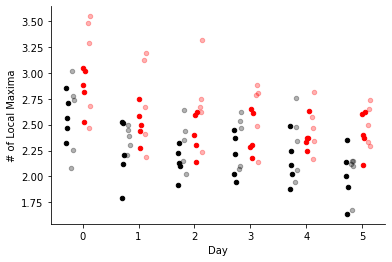

In [16]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['max_counts'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('# of Local Maxima')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "max_counts_summary.pdf"))

In [17]:
# lmm_res = MixedLM(cell_stats.df['field_width'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['field_width'], cell_stats.df[['ko', 
                                                               'day', 
                                                               'novfam', 
                                                               'lr', 
                                                               'ko_x_day', 
                                                               'ko_x_novfam', 
                                                               'novfam_x_day',
                                                               'speed',
                                                               'intercept']],cell_stats.df['mouse'], exog_re = cell_stats.df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_width
No. Observations: 120     Method:             REML       
No. Groups:       10      Scale:              0.0641     
Min. group size:  12      Log-Likelihood:     -21.9055   
Max. group size:  12      Converged:          Yes        
Mean group size:  12.0                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             -0.420    0.126 -3.327 0.001 -0.667 -0.173
day            -0.051    0.030 -1.676 0.094 -0.110  0.009
novfam         -0.267    0.116 -2.302 0.021 -0.495 -0.040
lr              0.326    0.047  6.900 0.000  0.233  0.419
ko_x_day       -0.158    0.223 -0.708 0.479 -0.595  0.279
ko_x_novfam    -0.133    0.093 -1.441 0.150 -0.315  0.048
novfam_x_day    0.479    0.162  2.946 0.003  0.160  0.797
speed           4.980   

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


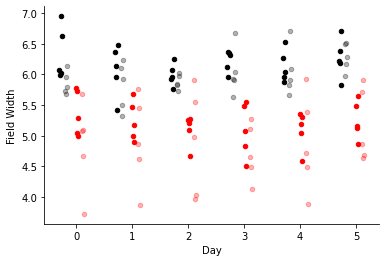

In [18]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['field_width'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

In [23]:
# lmm_res = MixedLM(cell_stats.df['avg_skewness'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['avg_skewness'], cell_stats.df[['ko', 
                                                                'day', 
                                                                'novfam', 
                                                                'lr', 
                                                                'ko_x_day', 
                                                                'ko_x_novfam', 
                                                                'novfam_x_day',
                                                                'speed',
                                                                'intercept']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_skewness
No. Observations: 120     Method:             REML        
No. Groups:       10      Scale:              0.0032      
Min. group size:  12      Log-Likelihood:     139.8527    
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko               0.023    0.046  0.512 0.609 -0.066  0.113
day              0.005    0.006  0.976 0.329 -0.005  0.016
novfam          -0.025    0.026 -0.975 0.330 -0.077  0.026
lr              -0.014    0.011 -1.318 0.187 -0.035  0.007
ko_x_day        -0.011    0.036 -0.290 0.772 -0.082  0.061
ko_x_novfam      0.072    0.021  3.504 0.000  0.032  0.113
novfam_x_day    -0.022    0.036 -0.618 0.536 -0.094  0.049
speed   

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


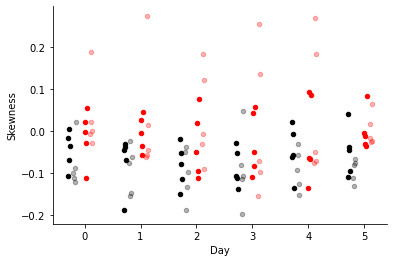

In [31]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_skewness'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Skewness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir, "skewness_summary.pdf"))

In [20]:
# lmm_res = MixedLM(cell_stats.df['avg_kurtosis'], cell_stats.df[['ko', 'day', 'novfam', 'lr', 'ko_x_day']], cell_stats.df['mouse'])
# lmm_resf = lmm_res.fit()
# print(lmm_resf.summary())

lmm_res = MixedLM(cell_stats.df['avg_kurtosis'], cell_stats.df[['ko', 
                                                                'dz', 
                                                                'novfam', 
                                                                'lr', 
                                                                'ko_x_day', 
                                                                'ko_x_novfam', 
                                                                'novfam_x_day',
                                                                'speed',
                                                                'intercept']], cell_stats.df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_kurtosis
No. Observations: 120     Method:             REML        
No. Groups:       10      Scale:              0.0467      
Min. group size:  12      Log-Likelihood:     -7.5908     
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              -0.129    0.165 -0.786 0.432 -0.452  0.193
dz               0.133    0.036  3.676 0.000  0.062  0.204
novfam           0.760    0.100  7.639 0.000  0.565  0.956
lr               0.050    0.040  1.231 0.218 -0.029  0.129
ko_x_day        -0.054    0.139 -0.387 0.699 -0.326  0.218
ko_x_novfam     -0.164    0.079 -2.075 0.038 -0.319 -0.009
novfam_x_day    -0.397    0.139 -2.864 0.004 -0.669 -0.125
speed   

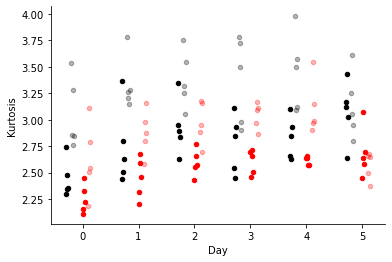

In [21]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    mask = (cell_stats.df['ko']==0) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m,std, color='black', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 1,std, color='black', alpha = .3, s=20)


for m, mouse in enumerate(ko_mice):
    mask = (cell_stats.df['ko']==1) & (cell_stats.df['mouse'] == mouse)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==0)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==0)]
    ax.scatter(10*x+.1*m + 3,std, color='red', s=20)
    
    std = cell_stats.df['avg_kurtosis'].loc[mask & (cell_stats.df['novfam']==1)]
    x = cell_stats.df['day'].loc[mask & (cell_stats.df['novfam']==1)]
    ax.scatter(10*x +.1*m + 4,std, color='red', alpha = .3, s=20)

ax.set_xticks(10.*np.arange(6) + 3)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')

ax.set_ylabel('Kurtosis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


fig.savefig(os.path.join(figdir, "kurtosis_summary.pdf"))

In [23]:
fam_cell_stats = CellStats(fam=True)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  0.932323    1    8  0.932323  10.190457  0.012760  0.560209   
1          day  0.597433    5   40  0.119487   9.749285  0.000004  0.549278   
2  Interaction  0.043326    5   40  0.008665   0.707018  0.621593  0.081201   

        eps  
0       NaN  
1  0.476382  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  8.061491  7.812182  0.249309  0.046274  5.387667    0.001  1.373024
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  8.233024  8.024221  0.208803  0.095348  2.189918  0.059928  1.250991
Day 1
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey  hedges
0  0  1  8.108177  7.796727  0.31145  0.147746  2.108008  0.068084  1.2042
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  0.932323    1    8  0.932323  10.190457  0.012760  0.560209   
 1          day  0.597433    5   40  0.119487   9.749285  0.000004  0.549278   
 2  Interaction  0.043326    5   40  0.008665   0.707018  0.621593  0.081201   
 
         eps  
 0       NaN  
 1  0.476382  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  8.061491  7.812182  0.249309  0.046274  5.387667    0.001  1.373024,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  8.233024  8.024221  0.208803  0.095348  2.189918  0.059928  1.250991,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey  hedges
  0  0  1  8.108177  7.796727  0.31145  0.147746  2.108008  0.068084  1.2042,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  8.011066  7.72

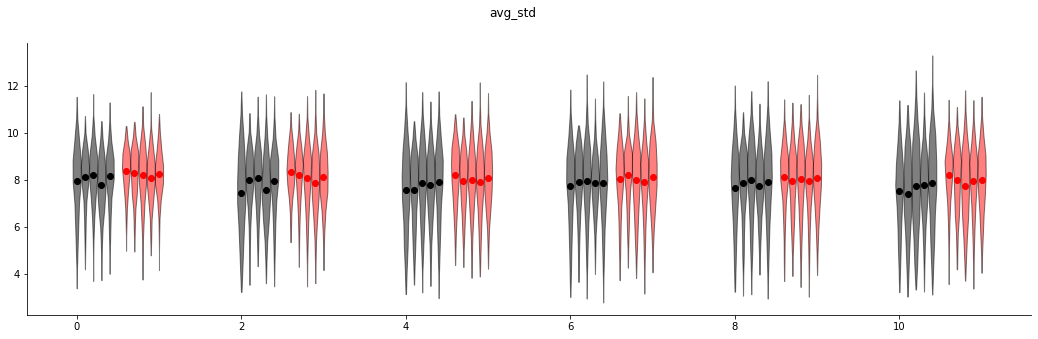

In [24]:
fig,ax = fam_cell_stats.violin_plots('avg_std')
fam_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'fam_avg_std_violin.pdf'),format = 'pdf')

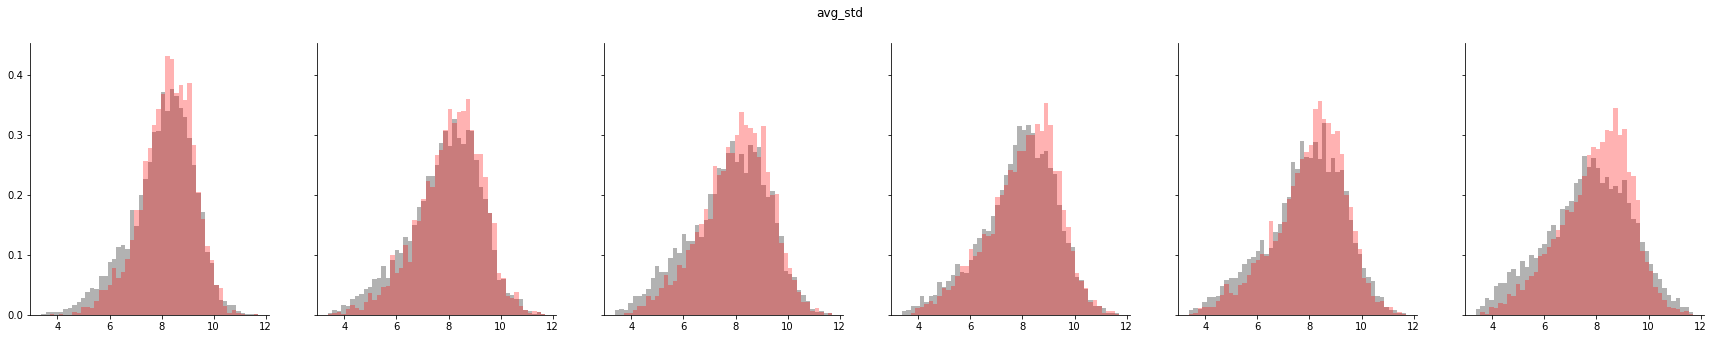

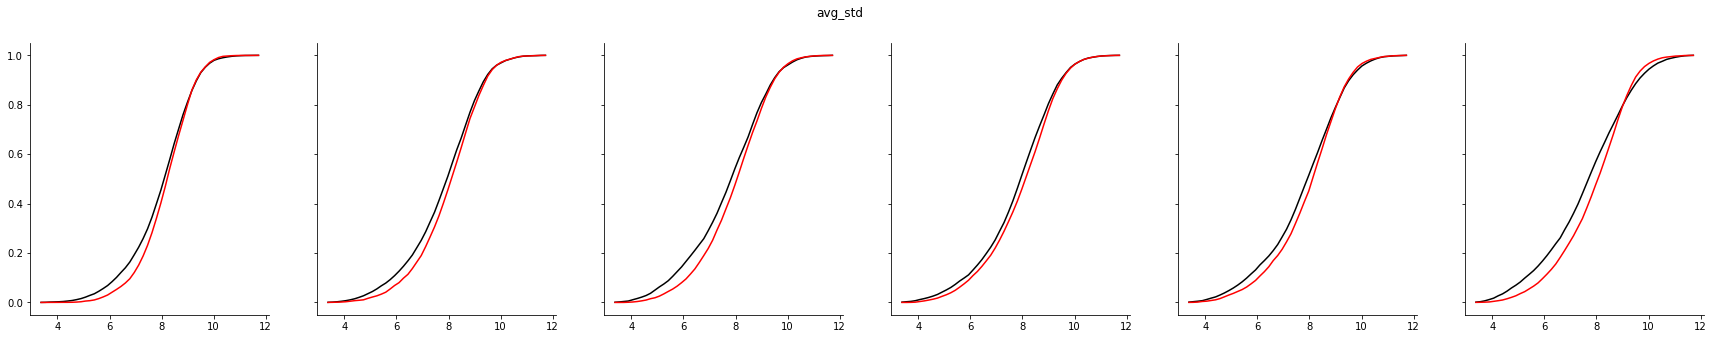

In [25]:
fig, ax = fam_cell_stats.combined_hist('avg_std', cumulative=False, smooth=False, fill = True)
fig.savefig(os.path.join(figdir, 'fam_avg_std_hist.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('avg_std', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'fam_avg_std_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  14.336115    1    8  14.336115  35.985124  0.000324  0.818120   
1          day   0.582437    5   40   0.116487   2.355670  0.057728  0.227476   
2  Interaction   0.141910    5   40   0.028382   0.573955  0.719501  0.066942   

        eps  
0       NaN  
1  0.492613  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)     diff        se          T  p-tukey    hedges
0  0  1  5.192308  6.169928 -0.97762  0.082277 -11.882068    0.001 -3.028094
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  5.367639  6.331645 -0.964006  0.254744 -3.784218  0.005354 -2.161735
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  5.243142  6.075245 -0.832103  0.237217 -3.507776  0.007987 -2.003817
Day 2
   A  B   mean(A)   mean(B)     diff        se        T 

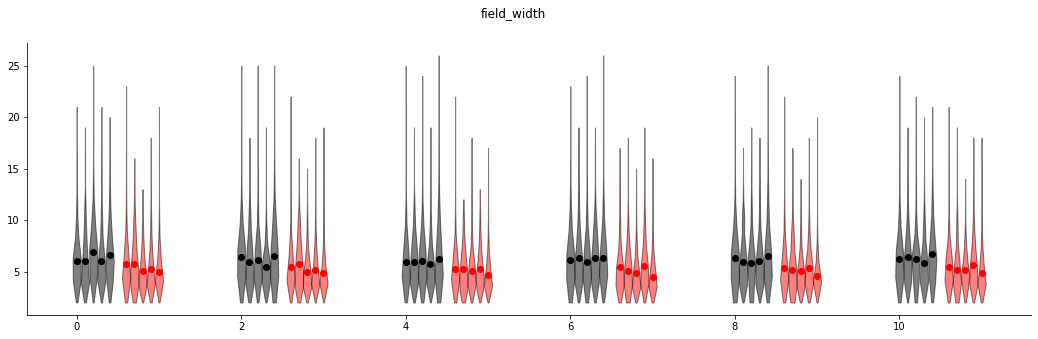

In [26]:
fig,ax = fam_cell_stats.violin_plots('field_width')
fam_cell_stats.mixed_anova('field_width')
fig.savefig(os.path.join(figdir, 'fam_field_width_violin.pdf'),format = 'pdf')

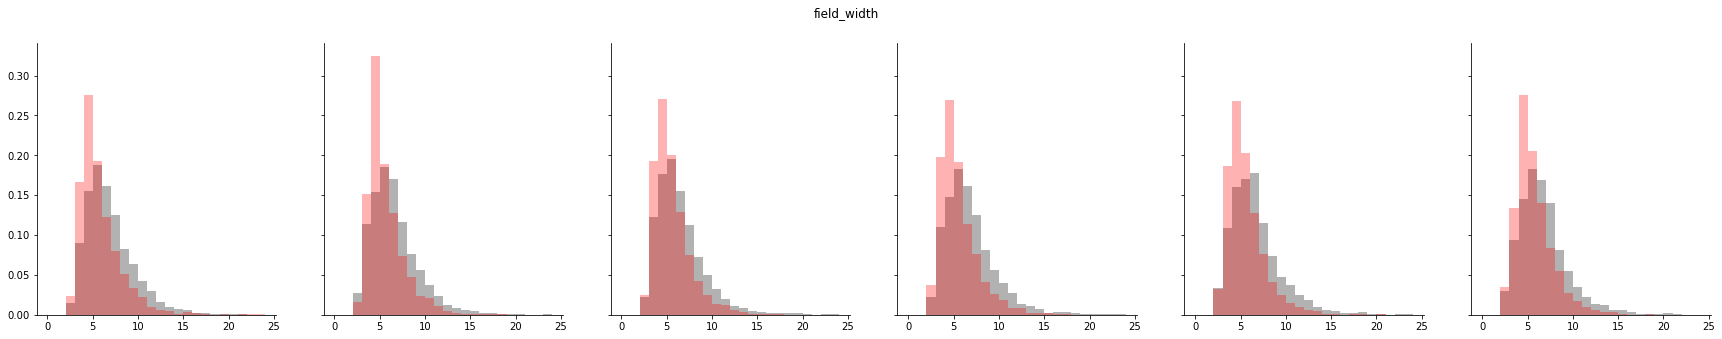

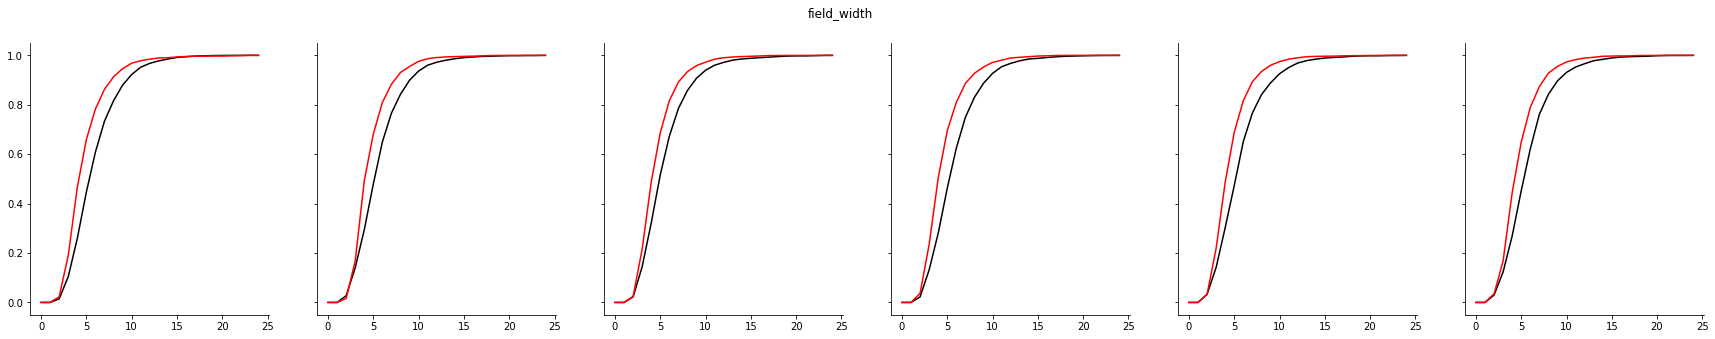

In [27]:
fig, ax = fam_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'fam_field_width_hist.pdf'),format = 'pdf')

fig, ax = fam_cell_stats.combined_hist('field_width', cumulative=True, smooth=True, fill= False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'fam_field_width_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  4.445098    1    8  4.445098  11.549300  0.009382  0.590778   
1          day  0.303769    5   40  0.060754   2.641098  0.037295  0.248198   
2  Interaction  0.069918    5   40  0.013984   0.607897  0.694253  0.070621   

        eps  
0       NaN  
1  0.642877  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.46477  1.920398  0.544371  0.070896  7.678421    0.001  1.956812
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey   hedges
0  0  1  2.554116   2.1442  0.409915  0.143638  2.853811  0.021353  1.63024
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.427825  1.907329  0.520495  0.165351  3.147821  0.013643  1.798193
Day 2
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  4.445098    1    8  4.445098  11.549300  0.009382  0.590778   
 1          day  0.303769    5   40  0.060754   2.641098  0.037295  0.248198   
 2  Interaction  0.069918    5   40  0.013984   0.607897  0.694253  0.070621   
 
         eps  
 0       NaN  
 1  0.642877  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.46477  1.920398  0.544371  0.070896  7.678421    0.001  1.956812,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey   hedges
  0  0  1  2.554116   2.1442  0.409915  0.143638  2.853811  0.021353  1.63024,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.427825  1.907329  0.520495  0.165351  3.147821  0.013643  1.798193,
     A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
  0  0  1  2.481099  1.852

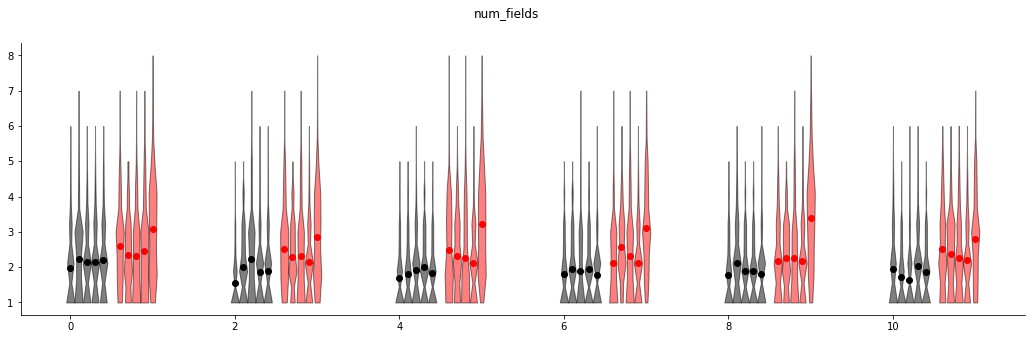

In [28]:
fig,ax = fam_cell_stats.violin_plots('num_fields')
fam_cell_stats.mixed_anova('num_fields')
# fig.savefig(os.path.join(figdir, 'fam_max_counts_violin.pdf'),format = 'pdf')

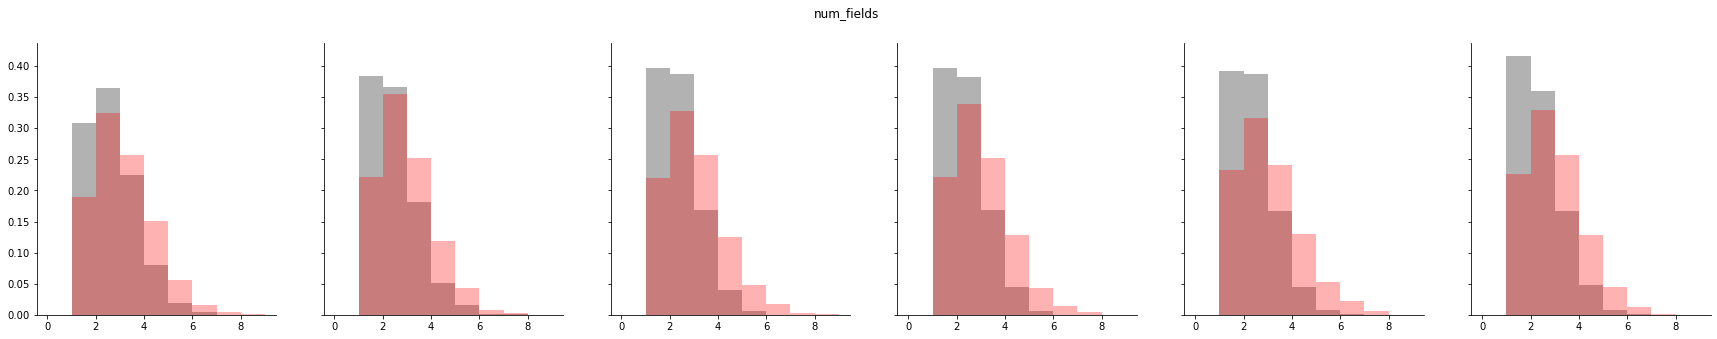

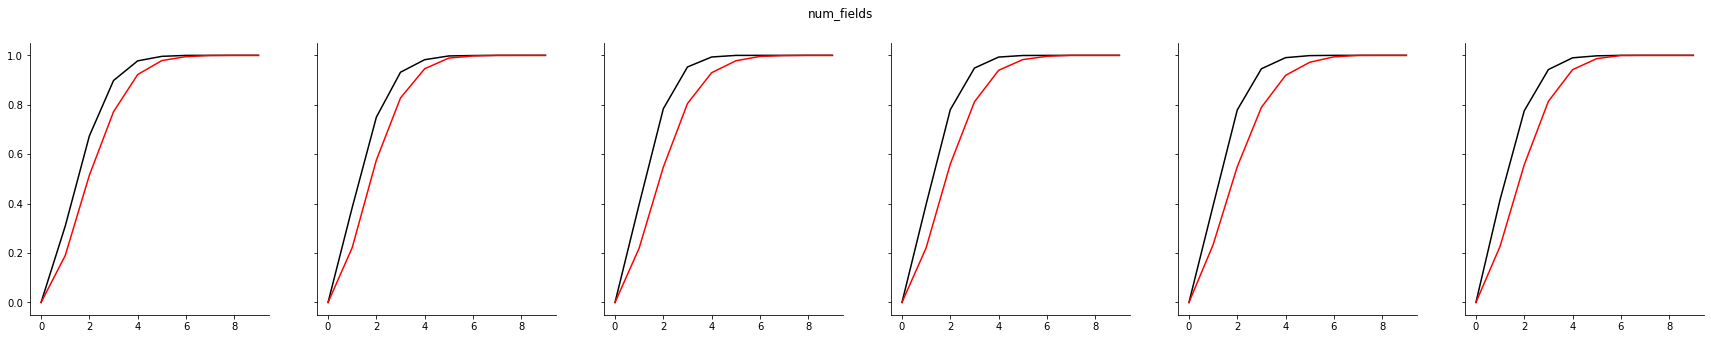

In [29]:
fig, ax = fam_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'fam_num_fields_hist.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('num_fields', cumulative=True, smooth=True, fill = False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'fam_num_fields_cumhist.pdf'),format = 'pdf')

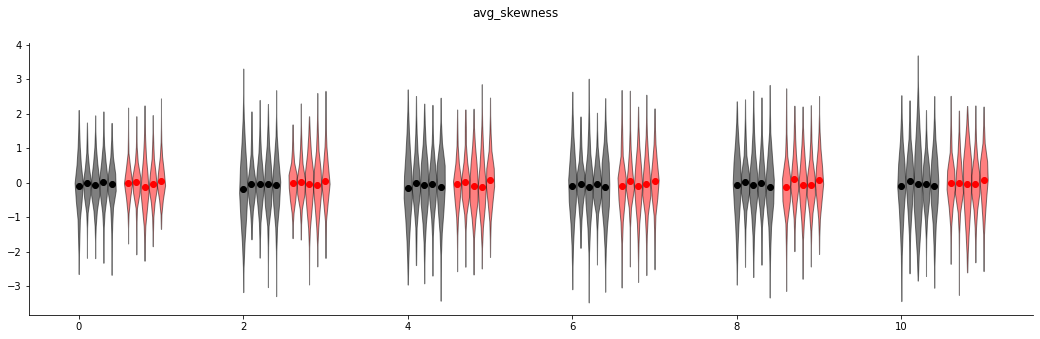

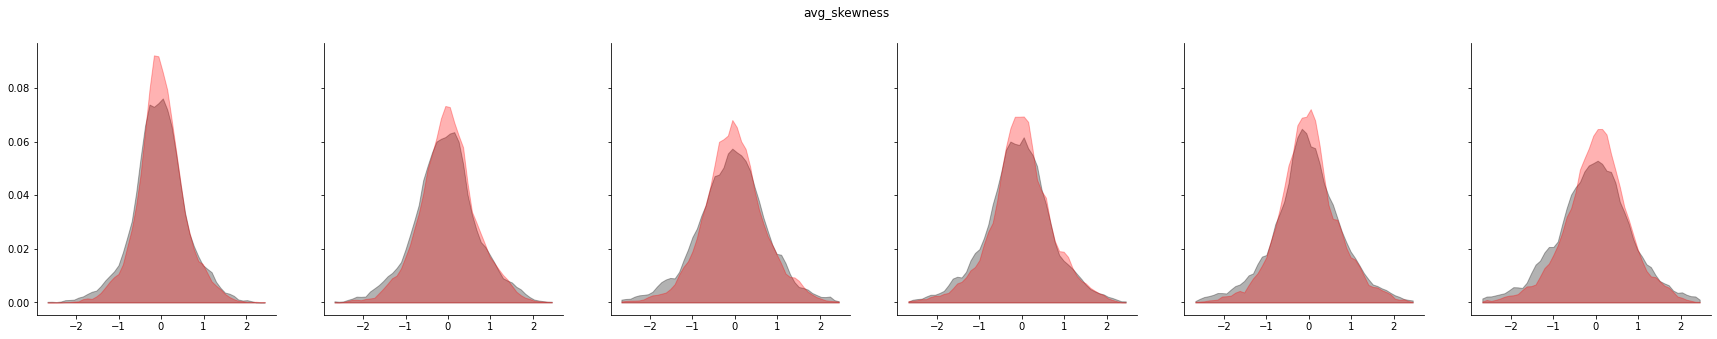

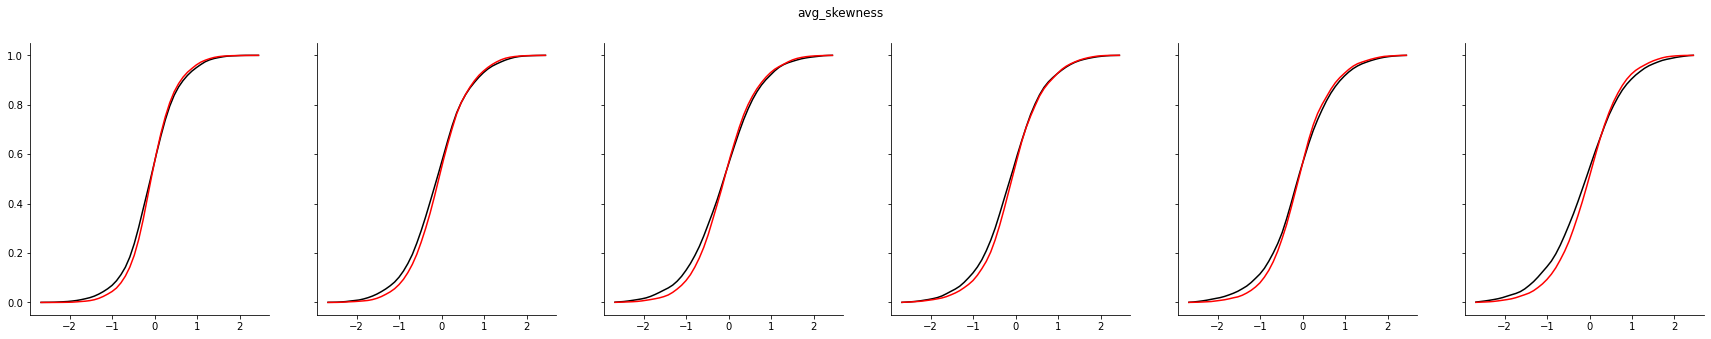

In [42]:
fig,ax = fam_cell_stats.violin_plots('avg_skewness')
# fam_cell_stats.mixed_anova('avg_skewness')

fig, ax = fam_cell_stats.combined_hist('avg_skewness', cumulative=False, smooth=True, fill = True)
fig.savefig(os.path.join(figdir, 'fam_avg_skewness.pdf'),format = 'pdf')
fig, ax = fam_cell_stats.combined_hist('avg_skewness', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'fam_avg_skewness_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F         p-unc  \
0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   

        np2       eps  
0  0.447898       NaN  
1  0.621230  0.477734  
2  0.086390       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379
Day 1
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461
Day 2
   A  B   mean(A)   mean(B)      diff       se      

{'anova':         Source        SS  DF1  DF2        MS          F         p-unc  \
 0      ko_ctrl  1.068538    1    8  1.068538   6.490086  3.430445e-02   
 1          day  1.647648    5   40  0.329530  13.120973  1.391515e-07   
 2  Interaction  0.094993    5   40  0.018999   0.756469  5.864374e-01   
 
         np2       eps  
 0  0.447898       NaN  
 1  0.621230  0.477734  
 2  0.086390       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff       se         T  p-tukey    hedges
 0  0  1  2.534523  2.801423 -0.266901  0.06835 -3.904926    0.001 -0.995153,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  2.251932  2.445312 -0.193381  0.101779 -1.900007  0.093966 -1.085379,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.451096  2.749516 -0.29842  0.188064 -1.586802  0.151218 -0.906461,
     A  B   mean(A)   mean(B)      diff       se        T   p-tukey    hedges
  0  0  1

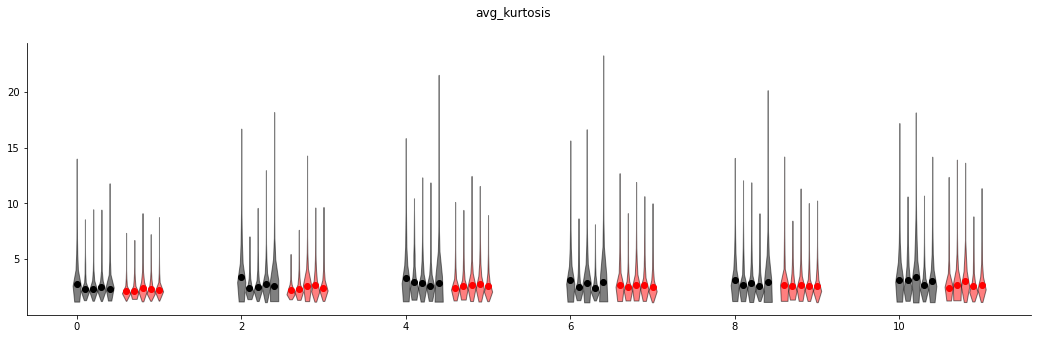

In [24]:
fig,ax = fam_cell_stats.violin_plots('avg_kurtosis')
fam_cell_stats.mixed_anova('avg_kurtosis')

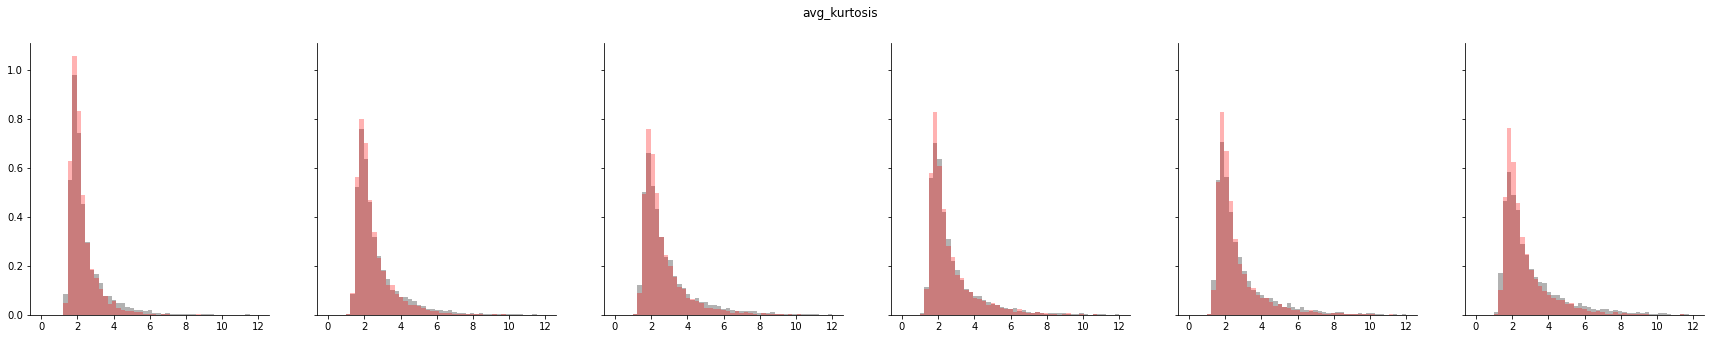

In [25]:
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins=np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:334: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:335: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

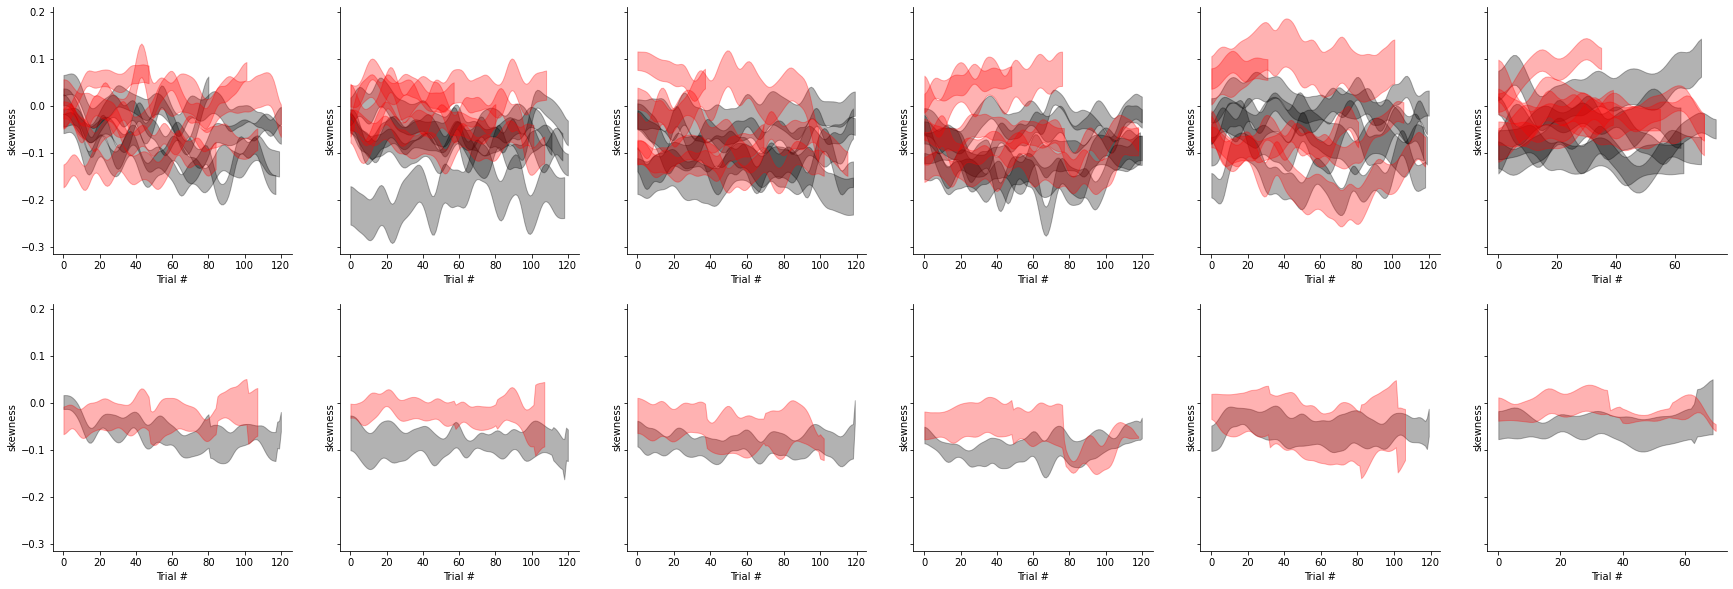

In [26]:
fam_cell_stats.across_trial_plot('skewness')

In [33]:
nov_cell_stats = CellStats(fam=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   

        eps  
0       NaN  
1  0.570457  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064
PostHov Tukey on each day
Day 0
   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442
Day 1
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey 

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  2.722317    1    8  2.722317  18.386612  0.002659  0.696816   
 1          day  0.707231    5   40  0.141446   5.698823  0.000464  0.416008   
 2  Interaction  0.127781    5   40  0.025556   1.029653  0.413430  0.114030   
 
         eps  
 0       NaN  
 1  0.570457  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  7.803159  7.377145  0.426014  0.058842  7.239927    0.001  1.845064,
 'day_tukey': [   A  B   mean(A)  mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.945582  7.45417  0.491412  0.155399  3.162261  0.013351  1.806442,
     A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  7.764424  7.348038  0.416386  0.10945  3.804352  0.005204  2.173237,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
  0  0  1  7.726642  7.

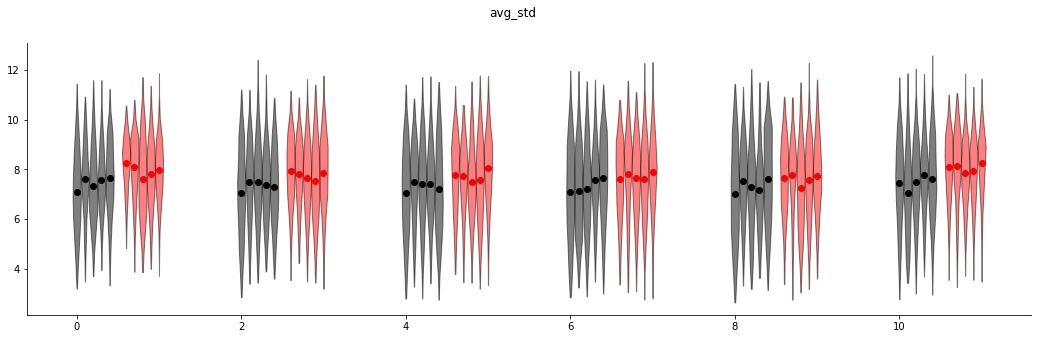

In [34]:
fig,ax = nov_cell_stats.violin_plots('avg_std')
nov_cell_stats.mixed_anova('avg_std')
# fig.savefig(os.path.join(figdir, 'nov_avg_std_violin.pdf'),format = 'pdf')

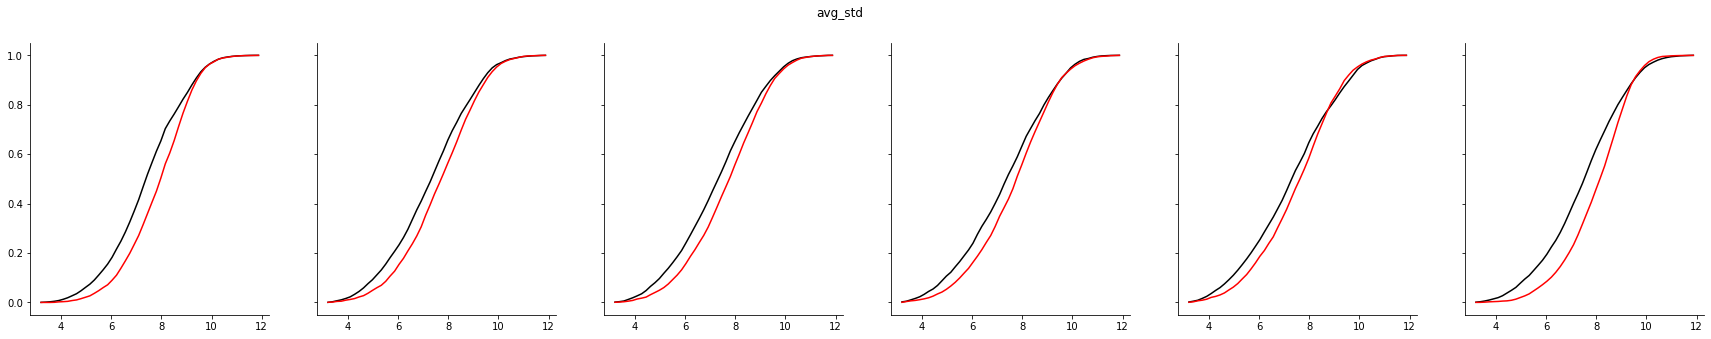

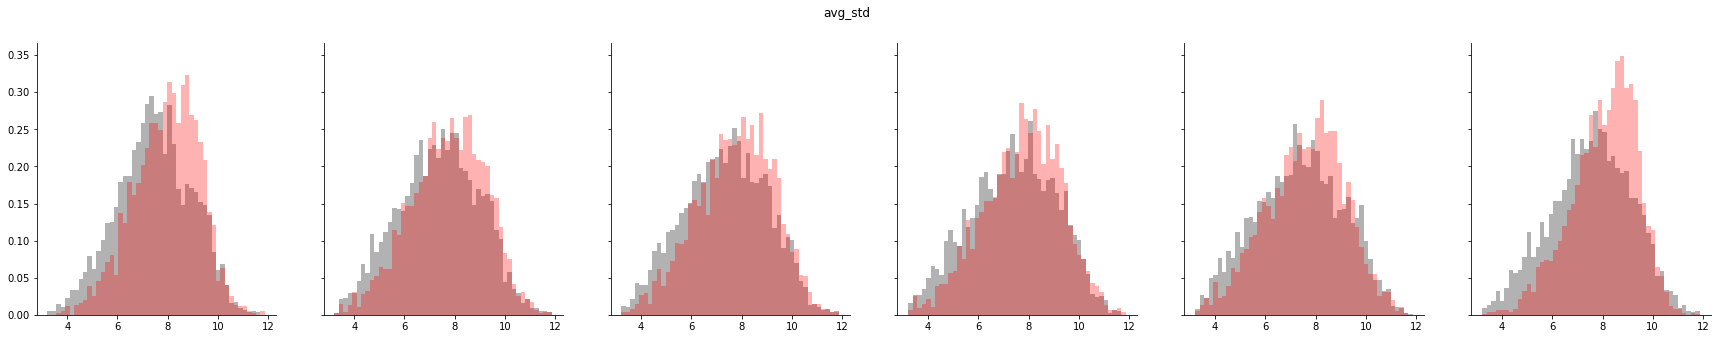

In [35]:
fig, ax = nov_cell_stats.combined_hist('avg_std', cumulative=True, smooth=True, fill = False)
fig.savefig(os.path.join(figdir, 'nov_avg_std_cumhist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('avg_std', cumulative=False, smooth=False, fill = True)
fig.savefig(os.path.join(figdir, 'nov_avg_std_hist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0      ko_ctrl  17.528132    1    8  17.528132  11.913427  0.008675  0.598261   
1          day   1.011448    5   40   0.202290   3.061769  0.019679  0.276788   
2  Interaction   0.261932    5   40   0.052386   0.792899  0.561170  0.090175   

        eps  
0       NaN  
1  0.684133  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1   4.9056  5.986591 -1.080991  0.134278 -8.050425    0.001 -2.051616
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0  0  1  4.850174  5.863484 -1.01331  0.334641 -3.028055  0.016358 -1.729777
Day 1
   A  B   mean(A)   mean(B)      diff      se         T   p-tukey    hedges
0  0  1  4.915144  5.816548 -0.901404  0.3734 -2.414045  0.042239 -1.379023
Day 2
   A  B   mean(A)   mean(B)      diff        se        T  p-tuke

{'anova':         Source         SS  DF1  DF2         MS          F     p-unc       np2  \
 0      ko_ctrl  17.528132    1    8  17.528132  11.913427  0.008675  0.598261   
 1          day   1.011448    5   40   0.202290   3.061769  0.019679  0.276788   
 2  Interaction   0.261932    5   40   0.052386   0.792899  0.561170  0.090175   
 
         eps  
 0       NaN  
 1  0.684133  
 2       NaN  ,
 'ko_ctrl_tukey':    A  B  mean(A)   mean(B)      diff        se         T  p-tukey    hedges
 0  0  1   4.9056  5.986591 -1.080991  0.134278 -8.050425    0.001 -2.051616,
 'day_tukey': [   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  4.850174  5.863484 -1.01331  0.334641 -3.028055  0.016358 -1.729777,
     A  B   mean(A)   mean(B)      diff      se         T   p-tukey    hedges
  0  0  1  4.915144  5.816548 -0.901404  0.3734 -2.414045  0.042239 -1.379023,
     A  B   mean(A)   mean(B)      diff        se        T  p-tukey   hedges
  0  0  1  4.891419  5

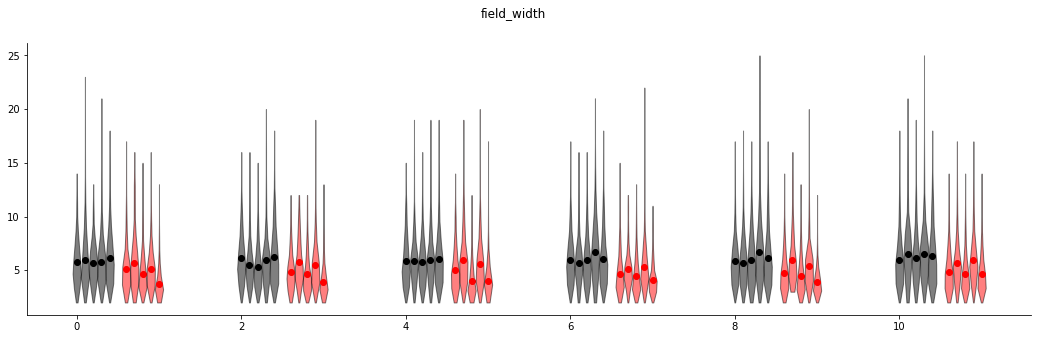

In [36]:
fig,ax = nov_cell_stats.violin_plots('field_width')
nov_cell_stats.mixed_anova('field_width')
# fig.savefig(os.path.join(figdir, 'nov_field_width_violin.pdf'),format = 'pdf')

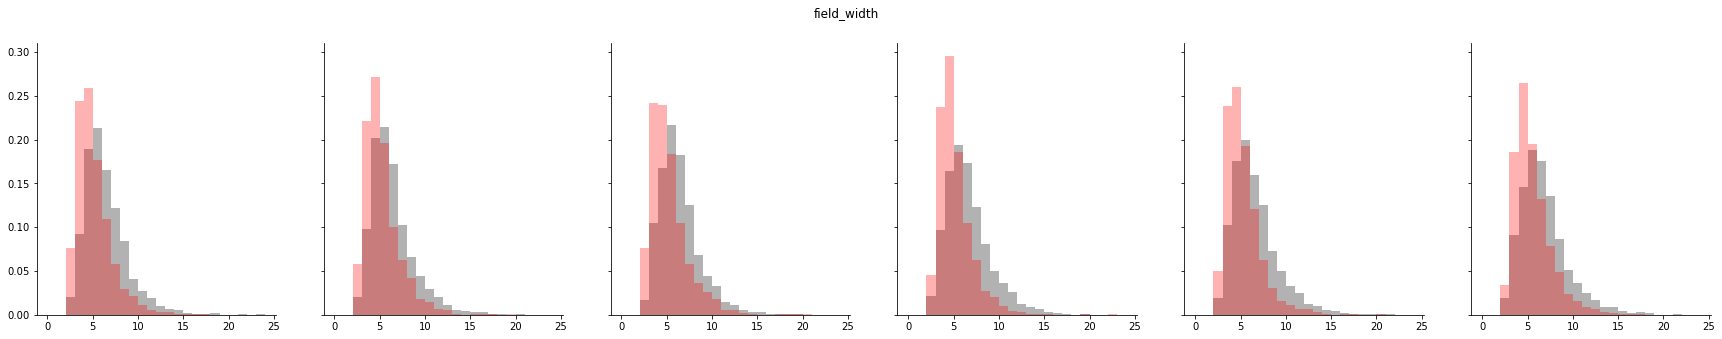

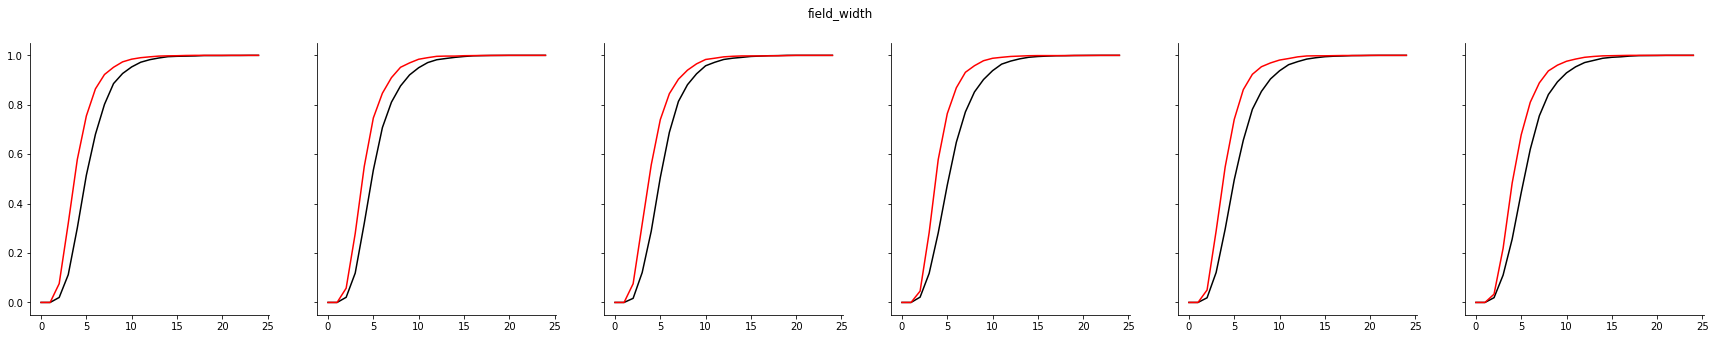

In [37]:
fig, ax = nov_cell_stats.combined_hist('field_width', cumulative=False, smooth=False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'nov_field_width_hist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('field_width', cumulative=True, smooth=True, fill = False, bins = np.arange(0,25))
fig.savefig(os.path.join(figdir, 'nov_field_width_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS          F     p-unc       np2  \
0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   

      eps  
0     NaN  
1  0.7302  
2     NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702
Day 2
   A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
0

{'anova':         Source        SS  DF1  DF2        MS          F     p-unc       np2  \
 0      ko_ctrl  8.839904    1    8  8.839904  14.135573  0.005546  0.638591   
 1          day  0.862700    5   40  0.172540   3.473845  0.010612  0.302762   
 2  Interaction  0.085674    5   40  0.017135   0.344987  0.882414  0.041341   
 
       eps  
 0     NaN  
 1  0.7302  
 2     NaN  ,
 'ko_ctrl_tukey':    A  B   mean(A)  mean(B)      diff        se         T  p-tukey    hedges
 0  0  1  2.785466  2.01779  0.767676  0.095521  8.036766    0.001  2.048135,
 'day_tukey': [   A  B   mean(A)   mean(B)      diff       se         T   p-tukey    hedges
  0  0  1  2.916478  2.173431  0.743047  0.25981  2.859967  0.021155  1.633757,
     A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
  0  0  1  2.812419  2.064347  0.748072  0.201857  3.705942  0.005991  2.11702,
     A  B   mean(A)   mean(B)     diff        se         T   p-tukey    hedges
  0  0  1  2.941739  2.018149  0.9

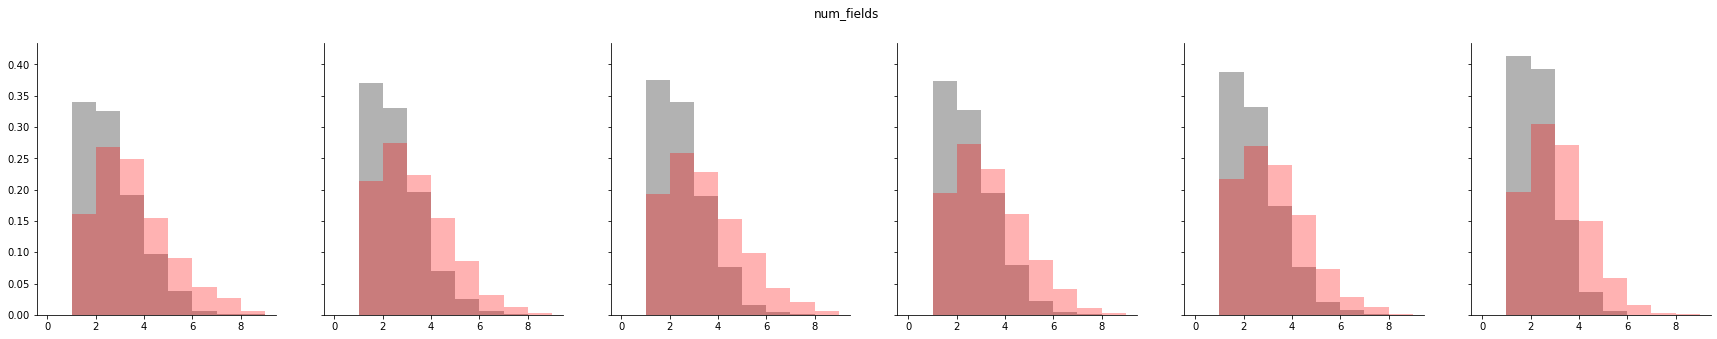

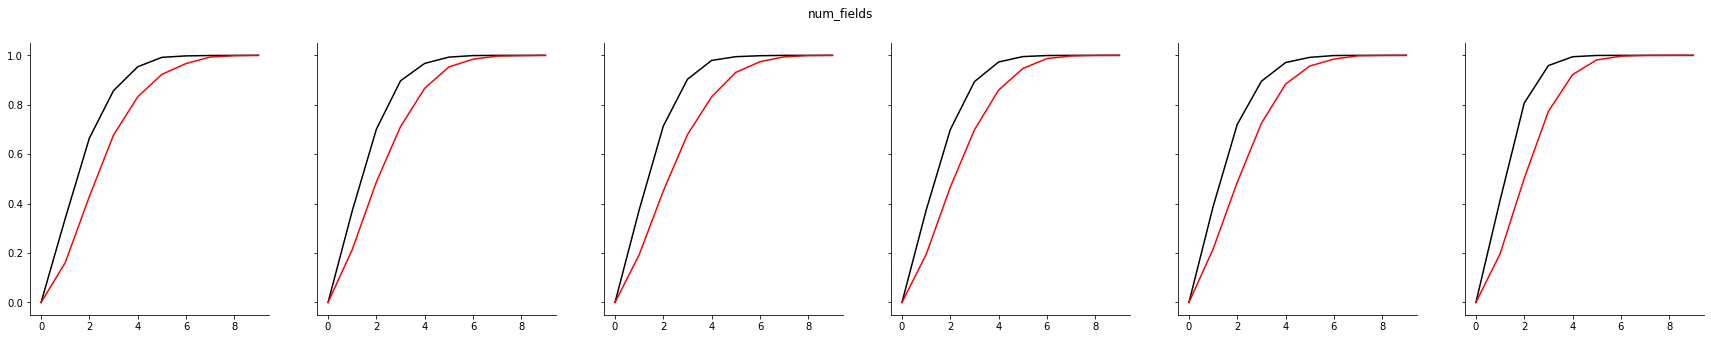

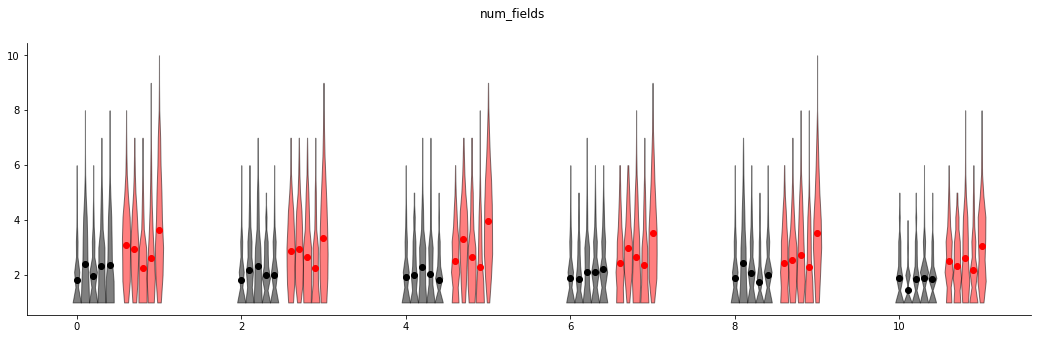

In [38]:
fig, ax = nov_cell_stats.combined_hist('num_fields', cumulative=False, smooth=False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'nov_num_fields_hist.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('num_fields', cumulative=True, smooth=True, fill = False, bins = np.arange(0,10))
fig.savefig(os.path.join(figdir, 'nov_num_fields_cumhist.pdf'),format = 'pdf')
fig,ax = nov_cell_stats.violin_plots('num_fields')
nov_cell_stats.mixed_anova('num_fields')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.211120    1    8  0.211120  5.227719  0.051552  0.395209   
1          day  0.004540    5   40  0.000908  0.229448  0.947459  0.027881   
2  Interaction  0.004314    5   40  0.000863  0.218001  0.952759  0.026527   

        eps  
0       NaN  
1  0.664937  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  0.028005 -0.090632  0.118637  0.023738  4.997737    0.001  1.273652
PostHov Tukey on each day
Day 0
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.035638 -0.078926  0.114564  0.047205  2.426936  0.041401  1.386388
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  0.025617 -0.092272  0.117889  0.068367  1.724357  0.122929  0.985039
Day 2
   A  B   mean(A)   mean(B)      diff        se       T   p-tukey   

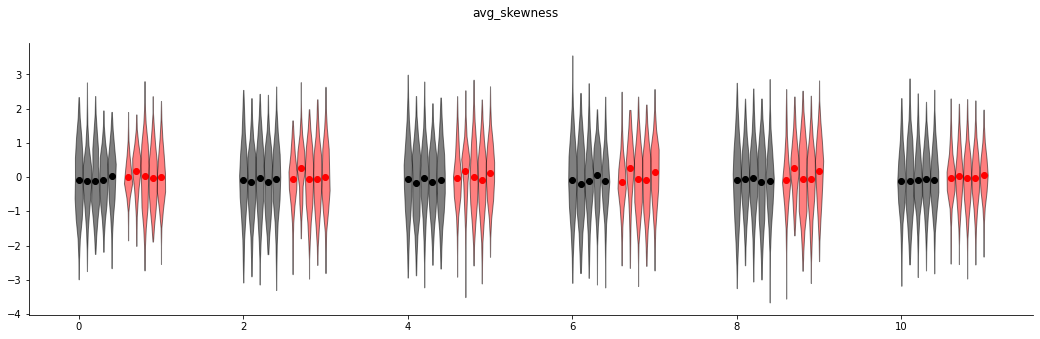

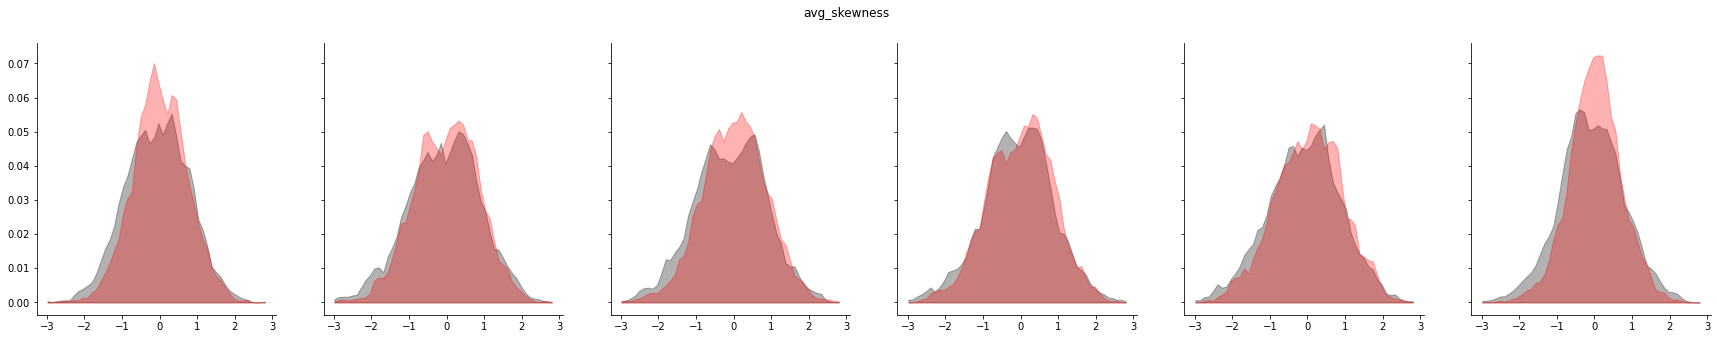

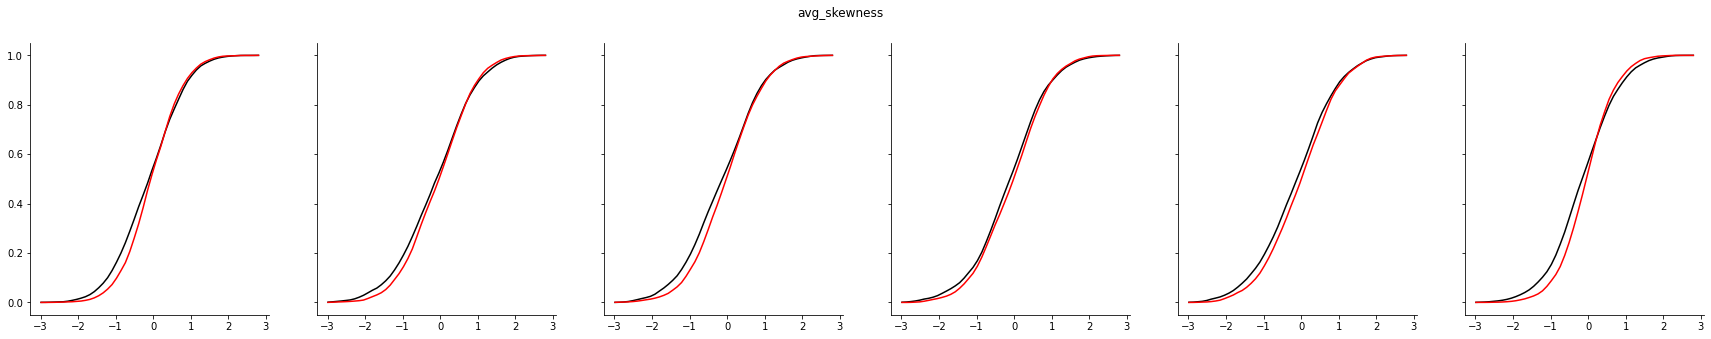

In [41]:
nov_cell_stats.mixed_anova('avg_skewness')
fig, ax = nov_cell_stats.violin_plots('avg_skewness')

fig, ax = nov_cell_stats.combined_hist('avg_skewness', cumulative=False, smooth=True, fill = True)
fig.savefig(os.path.join(figdir, 'nov_avg_skewness.pdf'),format = 'pdf')
fig, ax = nov_cell_stats.combined_hist('avg_skewness', cumulative=True, smooth=True, fill = False)

fig.savefig(os.path.join(figdir, 'nov_avg_skewness_cumhist.pdf'),format = 'pdf')

Mixed design ANOVA results
        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  2.695590    1    8  2.695590  9.578240  0.014780  0.544892   
1          day  1.756275    5   40  0.351255  8.914741  0.000009  0.527040   
2  Interaction  0.087548    5   40  0.017510  0.444387  0.814746  0.052625   

        eps  
0       NaN  
1  0.500399  
2       NaN  
PostHoc Tukey: KO vs Ctrl
   A  B   mean(A)   mean(B)      diff        se         T  p-tukey    hedges
0  0  1  2.866806  3.290724 -0.423917  0.080739 -5.250481    0.001 -1.338062
PostHov Tukey on each day
Day 0
   A  B  mean(A)  mean(B)     diff        se         T   p-tukey    hedges
0  0  1  2.62799  3.05683 -0.42884  0.215956 -1.985777  0.082308 -1.134375
Day 1
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hedges
0  0  1  2.878367  3.336915 -0.458548  0.147851 -3.101421  0.014632 -1.771687
Day 2
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey    hed

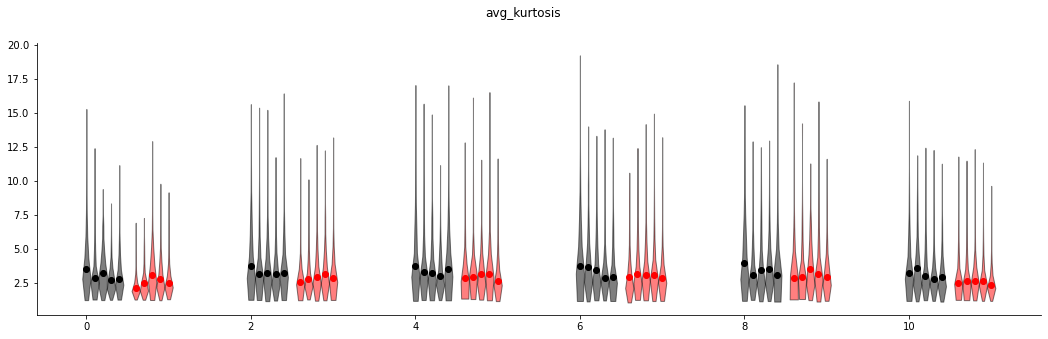

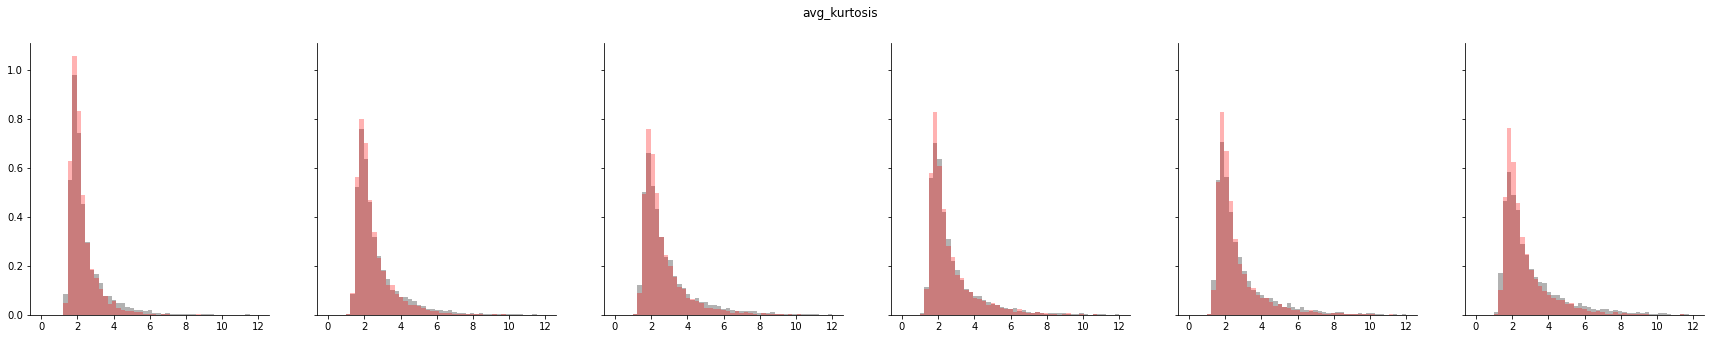

In [34]:
nov_cell_stats.mixed_anova('avg_kurtosis')
fig, ax = nov_cell_stats.violin_plots('avg_kurtosis')
fig, ax = fam_cell_stats.combined_hist('avg_kurtosis', cumulative=False, smooth=False, bins = np.linspace(0,12))

/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:334: RuntimeWarning: Mean of empty slice
  ko_mu, ko_sem = np.nanmean(ko_mu_arr, axis=0), sp.stats.sem(ko_mu_arr, axis=0, nan_policy='omit')
/home/mplitt/repos/STX3KO_analyses/STX3KO_analyses/single_cell_stats.py:335: RuntimeWarning: Mean of empty slice
  ctrl_mu, ctrl_sem = np.nanmean(ctrl_mu_arr, axis=0), sp.stats.sem(ctrl_mu_arr, axis=0, nan_policy='omit')


(<Figure size 2160x720 with 12 Axes>,
 array([[<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>],
        [<AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>,
         <AxesSubplot:xlabel='Trial #', ylabel='skewness'>]], dtype=object))

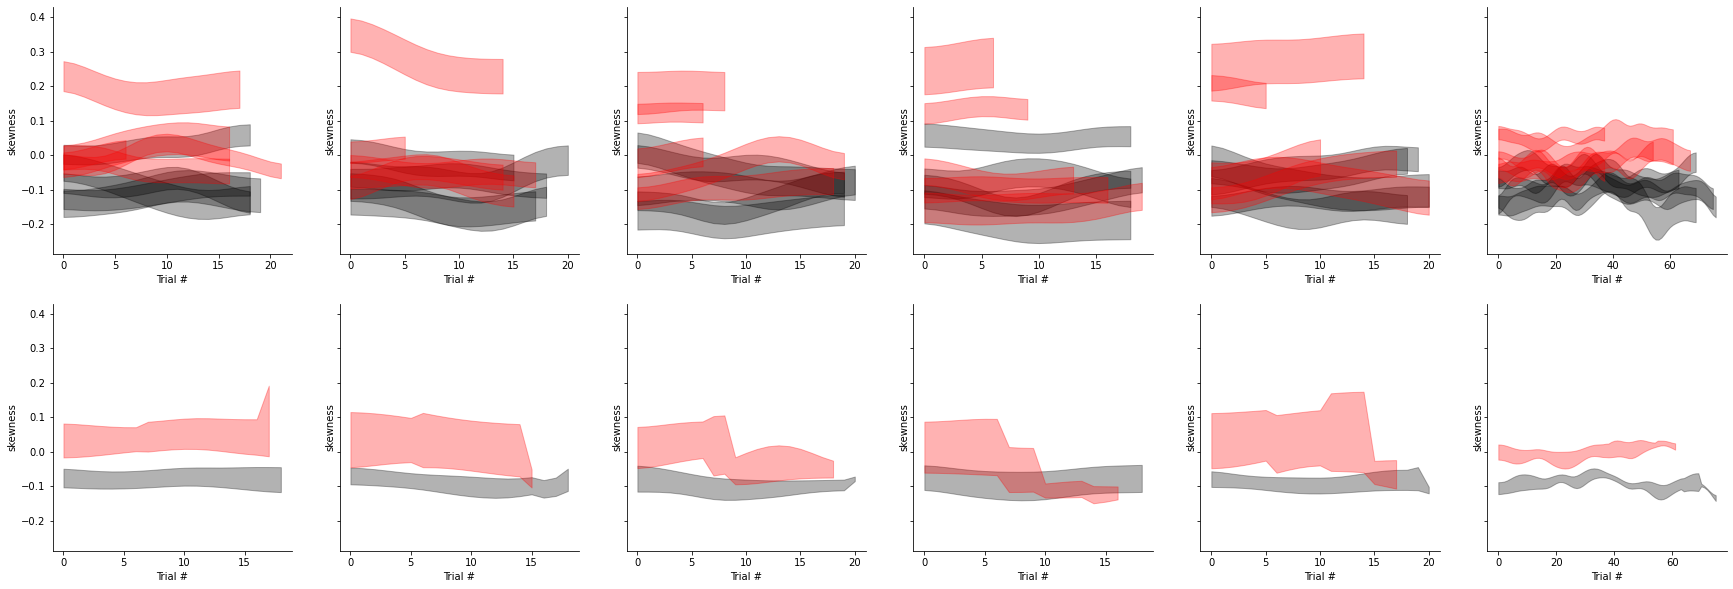

In [35]:
nov_cell_stats.across_trial_plot('skewness')